\section*{Summary of the Project} 

This project aims at implementing some of the tools of Miranda and Fackler's CompEcon toolkit in Python. The toolkit is available under https://github.com/lt1245/poly_base. These tools are mostly chosen in order to be able to solve heterogenous agents dynamic economic models using multidimensional function approximation methods more efficiently. The structure of the implemented tools follows the original toolkit as much as possible, but with some necessary tweaks. 

To motivate the main reasons for using this toolkit instead of the already existing procedures in Python, think of an example of solving a Bewley-Huggett-Aiyagari model (eg.: KMP.py on the github page) with approximating the value function:

- If using the more efficient Newton iteration instead of Bellman iteration, we are better of performing operations directly on the basis matrices (so numpy given cheb.fit or other packages are not good enough) then evaluating the approximand each time.
- Usually we can precompute some basis matrices (eg.: for shocks) and so we can save time by simply calculating the basis matrix for the endogenous state and take the tensor product with the other precomputed matrices.
- Sometimes monomial basis has advantages over the other approximations, see eg.: Judd,Maliar and Maliar (2011) , where thanks to their simplicity, expectation of the value function is calculated only once. Altough this is not implemented in the original CompEcon toolkit I found it useful to add it.

There are still some disadvantages of the current implementation that will be discussed in each section. This file contains the contents of interpolate.py (the functions of the toolkit) and Tests.ipynb (examples to demonstrate the toolkit) with additional comments. 

In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from scipy.interpolate import fitpack as spl
%matplotlib inline

\section*{interpolate.py}

\subsection*{Low-level functions}

The Python implementation of these functions were the primary objective of the project: 

- dprod: evaluates the tensor product of matrix A and B used for multidimensional approximation
- cheb_nodes  - different from the numpy version as both endpoints can be included or Lobatto nodes can be used.
- wealth_knot: Knots for splines that are optimal in some economic problems -
- cheb_basex and mono_basex: Chebyshev and Monomial basis matrices
- spli_basex: Spline basis matrix and derivative evaluation
- cheb_diff and mono_diff: Chebyshev and Monomial derivative operator

The (known) weaknesses of the implementation:

- Splines could work much faster. At this stage I am just using the scipy implementation. Previously I was playing around with another code that was 5 times faster but could not modify it so that it can produce derivatives. This is an issue, as unlike the Chebyshev and Monomials, evaluating the derivative of the approximand does not boil down to matrix multiplication.  
- Missing function for obtaining the inverse of the direct product of matrices (in case it is feasible). This would wonderfully speed up obtaining the coefficients of an approximation.
- Missing function for making a grid of the "state" variables. I do this manually at each example at this point.

In [2]:
@jit
def dprod(A,B):
    """calculate tensor product of two matrices
    with the same number of rows
    
    Parameters
    ----------
    A : array_like
        In multidimensional approximation this is the 
        1 dimensional basis matrix
    B: array_like
        In multidimensional approximation this is the 
        n - 1 dimensional basis matrix

    Returns
    -------
    Res :  ndarray
        Matrix of shape (m,n), where m = no. rows in A and
        n = no. columns in A * no. columns in B

    Notes
    -----
    """

    nobsa , na = A.shape
    nobsb , nb = B.shape
    Res = np.empty((nobsa,nb*na))
    if nobsa != nobsb:
        return 'A and B must have same number of rows'
    for t in range(nobsa):
        for ia in range(na):
            for ib in range(nb):            
                Res[t,nb*(ia-1)+ib] = A[t,ia] * B[t, ib]
    return Res

In [3]:
@jit
def cheb_nodes(p, nodetype=0):
    """Chebyshev nodes - for 1 dimension.

    Returns Chebyshev nodes

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the number of nodes
         - the lower bound of the approximation
         - the upper bound of the approximation
    nodetype : int
         - if 0 (default value) then use the usual nodes
         - if 1 then extend it to the endpoints
         - if 2 then us Lobatto nodes

    Returns
    -------
    x :  an array containing the Chebyshev nodes

    Notes
    -----
    """    
    n , a , b = p[0] , p[1] , p[2]
    s = (b-a) / 2 
    m = (b+a) / 2  
    if (nodetype < 2):  # usual nodes
        k = np.pi*np.linspace(0.5,n-0.5,n)  
        x = m - np.cos(k[0:n]/n) * s  
        if (nodetype == 1):  # Extend nodes to endpoints
            aa = x[0]  
            bb = x[-1]  
            x = (bb*a - aa*b)/(bb-aa) + (b-a)/(bb-aa)*x
    else: # Lobatto nodes
        k = np.pi*np.linspace(0,n-1,n)
        x = m - np.cos(k[0:n]/(n-1)) * s
    return x

In [4]:
@jit
def wealth_knot(p,degree = 1,curv  = 0.15):
    """Knots for wealth distributions - for 1 dimension.

    Returns commonly used knots that can be used with splines

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the number of nodes
         - the lower bound of the approximation
         - the upper bound of the approximation
    deg : int
            Degree of the splines.
            Default: create nodes instead of knots
    curve : float
            Weight on the lower end
            Default: 0.15

    Returns
    -------
    x :  an array containing the knots

    Notes
    -----
    Use these knots if you have boundary problems.
    """
    n , a , b = p[0] , p[1] , p[2]
    knots = np.linspace(a**curv, b**curv,n + 1 - degree) **(1.0/curv)
    return knots

\subsubsection*{1 dimensional basis matrices} 

In [5]:
@jit
def cheb_basex(p, x): 
    """Cheb basis matrix - for 1 dimension.

    Returns a matrix whose columns are the values of the (first kind) Chebyshev 
    polynomial of maximum degree n-1 evaluated at the points `x`. Degree 0 is 
    the constant 0.

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the order of approximation - the highest degree polynomial is n-1
         - the lower bound of the approximation
         - the upper bound of the approximation
    x : array_like
        Points at which to evaluate the b-splines.

    Returns
    -------
    bas : ndarray
        Matrix of shape (m,n), where ``m = len(x)`` and
        ``n - 1 = order(polynomial)``

    Notes
    -----
    Orthogonal polynomial
    """
    n , a , b = p[0] , p[1] , p[2]
    z = (2/(b-a)) * (x-(a+b)/2)
    m = z.shape[0]
    bas = np.empty((m, n));
    bas[:, 0] = 1.0
    bas[:, 1] = z[:]
    z = 2 * z
    for i in range(m):
        for j in range(2,n):
            bas[i, j] = z[i] * bas[i, j-1] - bas[i, j-2]
    return bas

In [6]:
@jit
def mono_basex(p, x): 
    """Monomials basis matrix- for 1 dimension.

    Returns a matrix whose columns are the values of the monomials of maximum 
    order n - 1 evaluated at the points `x`. Degree 0 is the constant 0.

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the order of approximation - the highest degree polynomial is n-1
         - the lower bound of the approximation
         - the upper bound of the approximation
    x : array_like
        Points at which to evaluate the b-splines.

    Returns
    -------
    bas : ndarray
        Matrix of shape (m,n), where ``m = len(x)`` and
        ``n - 1 = order(polynomial)``

    Notes
    -----
    Also known as the Vandermonde matrix
    """
    n , a , b = p[0] , p[1] , p[2]
    z = (2/(b-a)) * (x-(a+b)/2)
    m = z.shape[0]
    bas = np.empty((m, n));
    bas[:, 0] = 1.0
    for i in range(m):
        for j in range(1,n):
            bas[i, j] = z[i] * bas[i, j-1]
    return bas

In [7]:
@jit
def spli_basex(p, x ,knots=None , deg = 3 , order = 0 ):
    """Vandermonde type matrix for splines.

    Returns a matrix whose columns are the values of the b-splines of deg
    `deg` associated with the knot sequence `knots` evaluated at the points
    `x`.

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the number of knots
         - the lower bound of the approximation
         - the upper bound of the approximation
    x : array_like
        Points at which to evaluate the b-splines.
    deg : int
        Degree of the splines.
        Default: cubic splines
    knots : array_like
        List of knots. The convention here is that the interior knots have
        been extended at both ends by ``deg + 1`` extra knots - see augbreaks.
        If not given the default is equidistant grid
    order : int
        Evaluate the derivative of the spline
    Returns
    -------
    vander : ndarray
        Vandermonde like matrix of shape (m,n), where ``m = len(x)`` and
        ``n = len(augbreaks) - deg - 1``

    Notes
    -----
    The knots exending the interior points are usually taken to be the same
    as the endpoints of the interval on which the spline will be evaluated.

    """
    n , a , b = p[0] , p[1] , p[2]
    if knots is None:
        knots = np.linspace(a , b , n +  1 - deg)
    augbreaks = np.concatenate(( a * np.ones((deg)),knots, b * np.ones((deg))))
    m = len(augbreaks) - deg - 1
    v = np.empty((m, len(x)))
    d = np.eye(m, len(augbreaks))
    for i in range(m):
        v[i] = spl.splev(x, (augbreaks, d[i], deg),order)
    return v.T

\subsubsection*{Difference operators}

In [8]:
@jit
def cheb_diff(p):
    """Differentiating matrix for Chebyshev polynomials

    Returns a matrix which multiplied from the right with the coefficients
    of the Chebyshev polynomial returns the derivative of the respective 
    Chebyshev polynomial. Can be used instead to evaluate the basis matrix of
    the derivative of a Chebyshev polynomial.

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the number of knots = degree + 1 of the polynomial
         - the lower bound of the approximation
         - the upper bound of the approximation
    Returns
    -------
    D : ndarray
       Returns an upper triangular derivative operator matrix 

    Notes
    -----
    See usage in funbas
    """
    n , a , b = p[0] , p[1] , p[2]  
    D = np.zeros((n,n))
    for j in range(n):
        for i in range(int((n-j)/2)):
            D[j,j+1+2*i] = 4*((2*i+j+1))/(b-a)
    D[0,:] = D[0,:]/2
    return D

In [9]:
@jit
def mono_diff(p):  
    """Differentiating matrix for monomials

    Returns a matrix which multiplied from the right with the coefficients
    of the monomial returns the derivative of the respective 
    monomial. Can be used instead to evaluate the basis matrix of
    the derivative of a monomial.

    Parameters
    ----------
    p : array_like
        Parameter array containing:
         - the number of knots = degree + 1 of the polynomial
         - the lower bound of the approximation
         - the upper bound of the approximation
    Returns
    -------
    D : ndarray
       Returns an upper triangular derivative operator matrix 

    Notes
    -----
    See usage in funbas
    """
    n , a , b = p[0] , p[1] , p[2] 
    D = np.zeros((n,n))
    for j in range(n-1):
        D[j,j+1] = (j+1)/(b-a)*2
    return D

\subsection*{High-level functions}

The Python implementation of these functions were the secondary objective of the project:  

- funbas: Creates a multidimensional basis matrix, possibly with different approximation method for each dimension.
- goldenx: Vectorized golden section search for univariate functions

The (known) weaknesses of the implementation:

- funbas limits the possible information about the approximation as knots cannot be user-supplied for splines and splines are assumed to be cubic.
- goldenx requires that the univariate function that is to be maximized does not take additional arguments. 
- Missing function for obtaining coefficients of an approximation. I do this manually for each example.

In [10]:
def funbas(p,x,order = None, polynomial = None):
    """Creating a multidimensional approximation basis matrix

    Returns a matrix which is a tensor product of the basis matrices 

    Parameters
    ----------
    p : array_like
        Parameter matrix where each row contains:
         - the number of knots(for splines) or  degree + 1
         of the polynomial (Chebyshev or Monomials)
         - the lower bound of the approximation
         - the upper bound of the approximation
    x : array_like
        Matrix of evaluation points, one column for each dimension
        (note the difference with p)
    order : array_like
        Specifies which derivatives should be evaluated - default is zero
        Can only contain natural numbers (integration is not done yet)
    polynomial : array_like
        Specifies the type of approximation to be used, one for each dimension:
        default is Chebyshev for all dimensions. 
        Can only contain the following strings:
        - 'cheb' for Chebyshev
        - 'mono' for Monomials
        - 'spli' for Cubic Splines - cannot pre-specify knots
        
    Returns
    -------
    Phi0 : ndarray
       Returns the n dimensional (n = no. of rows in p) basis matrix.

    Notes
    -----
    To perform a multidimensional approximation, first create a product of the evaluation
    points for each dimension - see the example
    """        
    if x.ndim==1:
        if order is None:
            order = []
            order[0] = 0
        if polynomial is None:
            polynomial = []
            polynomial[0] = 'cheb'
        if polynomial=='cheb':
            Phi0=cheb_basex(p, x) @ np.linalg.matrix_power(cheb_diff(p),order[0])
        elif polynomial=='mono':
            Phi0=mono_basex(p, x) @ np.linalg.matrix_power(mono_diff(p),order[0])
        elif polynomial=='spli':
            Phi0=spli_basex(p, x, order = order[0]) 
    else:
        Phi0=np.ones((x.shape[0],1))  
        if order is None:
            order = np.zeros(x.shape[1], dtype=np.int)
        if polynomial is None:
            polynomial = ["cheb" for j in range(x.shape[1])]
        for j in range(x.shape[1]):
            if polynomial[j]=='cheb':
                Phi1=cheb_basex(p[j,:], x[:,j]) @ np.linalg.matrix_power(cheb_diff(p[j,:]),order[j])
            elif polynomial[j]=='mono':
                Phi1=mono_basex(p[j,:], x[:,j]) @ np.linalg.matrix_power(mono_diff(p[j,:]),order[j])
            elif polynomial[j]=='spli':
                Phi1=spli_basex(p[j,:], x[:,j], order = order[j]) 
            Phi0=dprod(Phi1,Phi0)
    return Phi0

In [11]:
@jit
def goldenx(f,a,b,tol = 1e-20):
    """Vectorized golden section search to maximize univariate functions simultaneously

    Returns the maximum and the maximal value of f

    Parameters
    ----------
    f : function
        Function that maps from R^n to R^n such that it is an augmented univariate function
    a : array_like
        The lower bound for the maximization, for each dimension
    b : array_like
        The upper bound for the maximization, for each dimension
    tol : float
        Specifies the default tolerance value (for the argument of f) - default is 10**(-10)        
    Returns
    -------
    x1 : ndarray
       Returns the n dimensional solution of the maximization.
    f1 : ndarray
       Returns the n dimensional maximum values.
    Notes
    -----
    What is missing: no additional arguments can be passed to f. The sig function is not nice. But pretty fast
    """        
    alpha1 = (3.0 - np.sqrt(5)) / 2.0
    alpha2 = 1.0 - alpha1
    d  = b - a
    x1 = a + alpha1 * d
    x2 = a + alpha2 * d
    s  = np.ones(x1.shape)
    f1 = f(x1)
    f2 = f(x2)
    d = alpha1 * alpha2 * d
    conv = 2.0
    while conv > tol:
        i = np.greater(f2,f1)
        not_i = np.logical_not(i)
        sig = np.ones(x1.shape)
        sig[not_i] = -1.0
        x1[i] = x2[i]
        f1[i] = f2[i]
        d = alpha2 * d
        x2 = x1 + np.multiply(np.multiply(np.multiply(s,(i^(not_i))),d),sig)
        s = np.sign(x2-x1)
        f2 = f(x2)
        conv = np.max(d)  
    return x1, f1

\section*{Tests.ipynb}

\subsection*{Examples}

The following examples demonstrate how and why to use the toolkit: 

- dprod for large matrices
- Approximating cos(x) and it's derivative using:
    
    - Monomials 
    - Chebyshev polynomial
    - Cubic splines with pre-specified knots (with an additional approximation for exp(-x) with wealth_knot)
    - Cubic splines with equidistant knots
    
- Approximate the multidimensional banana function using:

    - funbas and Chebyshev polynomials for both dimensions
    - dprod and splines for both dimensions
    
- goldenx to maximize the quadratic function with different solution for each dimension


In [12]:
%%timeit
A1 = np.random.randn(100,10)
B1 = np.random.randn(100,1000)
C1 = dprod(A1,B1)

The slowest run took 73.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 9.8 ms per loop


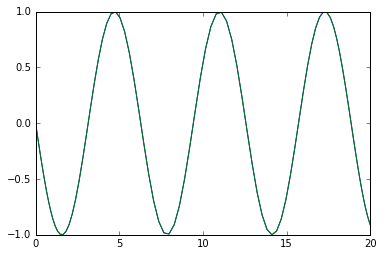

In [13]:
#Approximate cos(x) with Chebychev
n = 20 # number of nodes
x = cheb_nodes((n,0,20),2)  #create the Chebychev (Lobatto) nodes
y = np.cos(x) 
Phi = cheb_basex((n,0,20),x) # create the basis matrix
#Invert to get polynomial coefficients
coeff = np.linalg.solve(Phi,y)  #get the coefficients
D = cheb_diff((n,0,20))
x1 = cheb_nodes((100,0,20),0)
y1 = np.cos(x1)
z1 = -np.sin(x1)
Phi1 = cheb_basex((n,0,20),x1)
y_approx = Phi1 @ coeff
z_approx = Phi1 @ D @ coeff    #Approximate the derivative using the difference operator
plt.plot(x1,z1)
plt.plot(x1,z_approx)
plt.show()

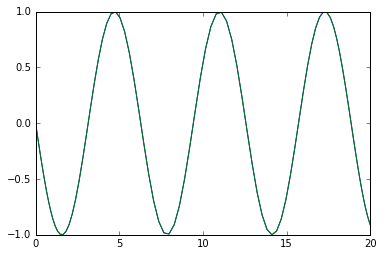

In [14]:
#Approximate cos(x) with monomial
n = 20
x = cheb_nodes((n,0,20),2)
y = np.cos(x)
Phi = mono_basex((n,0,20),x)
#Invert to get polynomial coefficients
coeff = np.linalg.solve(Phi,y)
D = mono_diff((n,0,20))
x1 = cheb_nodes((100,0,20),0)
y1 = np.cos(x1)
z1 = -np.sin(x1)
Phi1 = mono_basex((n,0,20),x1)
y_approx = Phi1 @ coeff
z_approx = Phi1 @ D @ coeff
plt.plot(x1,z1)
plt.plot(x1,z_approx)
plt.show()

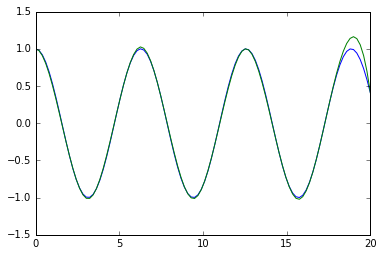

In [15]:
#Approximate cos(x) with cubic splines and pres-pecified knots
n = 9
p = (n,0,20)
x = np.linspace(0,20,n)
knots = np.array([0,np.pi,2*np.pi,3*np.pi,4*np.pi,5*np.pi,20])
k = 3
y = np.cos(x)
Phi=spli_basex(p,x,knots,k)
coeff = np.linalg.solve(Phi,y)
x1 = np.linspace(0,20,100)
y1 = np.cos(x1)
Phi1 = spli_basex(p,x1,knots,k)
y_approx = Phi1 @ coeff
plt.plot(x1,y1)
plt.plot(x1,y_approx)
plt.show()

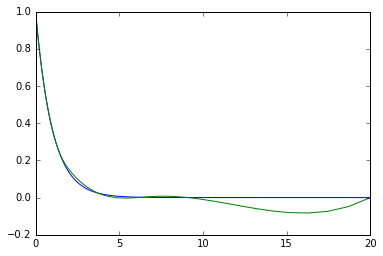

In [16]:
#Approximate exp(-x) with cubic splines and wealth_knot
n = 10
p = (n,0,20)
x = wealth_knot(p,1,curv  = 0.15) 
knots = wealth_knot(p,3,curv  = 0.15)
y = np.exp(-x)
Phi = spli_basex(p,x,knots)
coeff = np.linalg.solve(Phi,y)
x1 =wealth_knot([100,0,20],1,curv  = 0.15)
y1 = np.exp(-x1)
Phi1 = spli_basex(p,x1,knots)
y_approx = Phi1 @ coeff
plt.plot(x1,y1)
plt.plot(x1,y_approx)
plt.show()

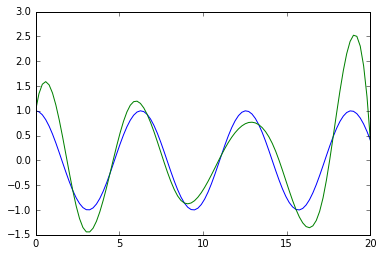

In [17]:
#Approximate cos(x) with cubic splines with automatic equidistant knots
n = 10
p = (n,0,20)
x = np.linspace(0,20,n)
y = np.cos(x)
Phi=spli_basex(p,x)
coeff = np.linalg.solve(Phi,y)
x1 = np.linspace(0,20,100)
y1 = np.cos(x1)
Phi1 = spli_basex(p,x1)
y_approx = Phi1 @ coeff
plt.plot(x1,y1)
plt.plot(x1,y_approx)
plt.show()

In [18]:
# Approximate the banana function
n = 20
P = np.array(((n,-3,3),(n,-3,3)))
Polyname = ('cheb','cheb')
Order = (0,0)
x = cheb_nodes(P[0,:],2)
s = np.concatenate([np.transpose(np.kron(np.ones((1,n)),x)),np.transpose(np.kron(x,np.ones((1,n))))],1)
#The banana - vectorized
def Banana(s):
    return (1-s[:,0])**2 + 100 * (s[:,1]-s[:,0]**2)**2
y = Banana(s)
Phi3 = funbas(P,s,Order,Polyname)
coeff = np.linalg.solve(Phi3,y)
#Generate the approximand
n1 = 100
x1 = np.linspace(-3,3,n1)
s1 = np.concatenate([np.transpose(np.kron(np.ones((1,n1)),x1)),np.transpose(np.kron(x1,np.ones((1,n1))))],1)
y1 = Banana(s1)
Phi3a = funbas(P,s1,Order,Polyname)
y_approx= Phi3a @ coeff

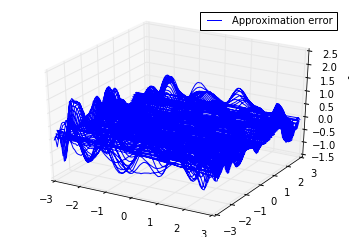

In [19]:
#3D Plot
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(s1[:,0], s1[:,1], y1-y_approx, label='Approximation error')
ax.legend()

plt.show()

In [20]:
# Approximate the banana function with splines using dprod
n_1 = 30
n_2 = 30
P = np.array(((n_1,-3,3),(n_2,-1,2)))
Polyname = ('spli','spli')
Order = (0,0)
x_1 = np.linspace(-3,3,n_1)
x_2 = np.linspace(-1,2,n_2)
x_1 = np.reshape(x_1,(n_1,1))
x_2 = np.reshape(x_2,(n_2,1))
s = np.concatenate((np.kron(np.ones((n_2,1)),x_1),np.kron(x_2,np.ones((n_1,1)))),1)
#The banana - vectorized
def Banana(s):
    return (1-s[:,0])**2 + 100 * (s[:,1]-s[:,0]**2)**2
y = Banana(s)
Phi1 = spli_basex(P[0],s[:,0])
Phi2 = spli_basex(P[1],s[:,1])
Phi3 = dprod(Phi2,Phi1)
coeff = np.linalg.solve(Phi3,y)
#Generate the approximand
n1 = 200
n2 = 200
x1 = np.linspace(-3,3,n1)
x2 = np.linspace(-1,2,n2)
x1 = np.reshape(x1,(n1,1))
x2 = np.reshape(x2,(n2,1))
s1 = np.concatenate((np.kron(np.ones((n2,1)),x1),np.kron(x2,np.ones((n1,1)))),1)
y1 = Banana(s1)
Phi1a = spli_basex(P[0],s1[:,0])
Phi2a = spli_basex(P[1],s1[:,1])
Phi3a = dprod(Phi2a,Phi1a)
y_approx= Phi3a @ coeff

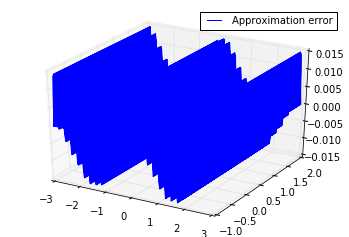

In [21]:
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(s1[:,0], s1[:,1], y1-y_approx, label='Approximation error')
ax.legend()

plt.show()

In [22]:
# Minimize the quadratic function with different intercepts using goldenx
a = 2 * np.ones((10,1))
b = 100 * np.ones(a.shape)
def quadratic(x):
    c = np.linspace(10,50,len(x))
    c = np.reshape(c,x.shape)
    return  - (x - c) ** 2
x_star, f_star = goldenx(quadratic,a,b)
print(x_star)
print(f_star)

[[ 10.        ]
 [ 14.44444444]
 [ 18.88888889]
 [ 23.33333333]
 [ 27.77777778]
 [ 32.22222222]
 [ 36.66666667]
 [ 41.11111111]
 [ 45.55555556]
 [ 50.        ]]
[[-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]
 [-0.]]


In [23]:
%%timeit
goldenx(quadratic,a,b)

100 loops, best of 3: 8.46 ms per loop
